#Imports

In [1]:
%matplotlib inline
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras import optimizers, losses, metrics
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import to_categorical
from collections import defaultdict, OrderedDict
from keras.callbacks import Callback
from keras.optimizers import SGD
import keras.backend as K
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import kde  # requires kde.py from https://github.com/artemyk/ibsgd/tree/iclr2018
import matplotlib.animation as animation
from IPython.display import HTML
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

# code heavily editted from https://github.com/artemyk/ibsgd/blob/iclr2018/loggingreporter.py

Using TensorFlow backend.


#Get Data

In [2]:
#get data
from keras.datasets import mnist

# y data is list of values 0-9
(x_train, y_train_not_hot), (x_test, y_test_not_hot) = mnist.load_data()

# convert to one hot
num_classes = 10
y_train = to_categorical(y_train_not_hot, num_classes)
y_test = to_categorical(y_test_not_hot, num_classes)

#picture info
height = x_train.shape[1] 
width = x_train.shape[2]

x_train = x_train.reshape(x_train.shape[0], height, width, 1)
x_test = x_test.reshape(x_test.shape[0], height, width, 1)

channels = x_train.shape[3]

#x values in range 0 to 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train/=255
x_test/=255

x_train.shape, y_train.shape

11493376/11490434 [==============================] - 1s 0us/step


((60000, 28, 28, 1), (60000, 10))

# **Mututal Information Calculation**

In [0]:
# Functions to return upper and lower bounds on entropy of layer activity
noise_variance =  0.0735      # 1e-1  Saxe  # Added Gaussian noise variance
Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
entropy_func_upper = K.function([Klayer_activity,], [kde.entropy_estimator_kl(Klayer_activity, noise_variance),])
entropy_func_lower = K.function([Klayer_activity,], [kde.entropy_estimator_bd(Klayer_activity, noise_variance),])

# nats to bits conversion factor
nats2bits = 1.0/np.log(2) 

In [0]:
# Save indexes of tests data for each of the output classes
test_label_indxs = {}
for i in range(num_classes):
    test_label_indxs[i] = (y_test_not_hot == i)

# calculate p(y)
test_label_probs = np.mean(y_test, axis=0)

H_Y = -np.sum(test_label_probs*np.log2(test_label_probs))

In [0]:
def mi_kde(activity):
    
    #print(activity.shape)
    
    # Compute marginal entropies
    h_upper = entropy_func_upper([activity,])[0]
    h_lower = entropy_func_lower([activity,])[0]

    # Layer activity given input. This is simply the entropy of the Gaussian noise
    hM_given_X = kde.kde_condentropy(activity, noise_variance)

    # upper
    MI_XM_upper = nats2bits * (h_upper - hM_given_X)
    H_M_upper = nats2bits * h_upper

    # lower 
    MI_XM_lower = nats2bits * (h_lower - hM_given_X)
    H_M_lower = nats2bits * h_lower

    hM_given_Y_upper=0.
    for i in range(num_classes):
      hcond_upper = entropy_func_upper([activity[test_label_indxs[i],:],])[0]
      hM_given_Y_upper += test_label_probs[i] * hcond_upper
    hM_given_Y_lower=0.
    for i in range(num_classes):
      hcond_lower = entropy_func_lower([activity[test_label_indxs[i],:],])[0]
      hM_given_Y_lower += test_label_probs[i] * hcond_lower

    # upper
    MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)
    
    # lower
    MI_YM_lower = nats2bits * (h_lower - hM_given_Y_lower)
    
    return MI_XM_upper, H_M_upper, MI_XM_lower, H_M_lower, MI_YM_upper, MI_YM_lower

# Investigating KDE

(3.306771755218506, 0.13110113143920898)

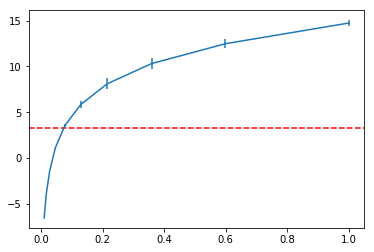

In [6]:
# Finding best sigma squared

def h_y_kde(sigma2, y_test):
    
    # Functions to return upper and lower bounds on entropy of layer activity
    noise_variance = sigma2.item() # converts to native python float
    Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
    entropy_func_upper = K.function([Klayer_activity,], [kde.entropy_estimator_kl(Klayer_activity, noise_variance),])
    entropy_func_lower = K.function([Klayer_activity,], [kde.entropy_estimator_bd(Klayer_activity, noise_variance),])

    # nats to bits conversion factor
    nats2bits = 1.0/np.log(2) 

    H_Y_KDE = 0.5*(entropy_func_upper([y_test,])[0]+entropy_func_lower([y_test,])[0])
    err = 0.5*(entropy_func_upper([y_test,])[0]-entropy_func_lower([y_test,])[0])
    return H_Y_KDE, err

sigma2s = np.logspace(-2, 0, num=10, base=10.0)
plt.errorbar(sigma2s, [h_y_kde(sigma2, y_test)[0] for sigma2 in sigma2s], yerr=[h_y_kde(sigma2, y_test)[1] for sigma2 in sigma2s])
plt.axhline(y=H_Y, color='r', linestyle='--', label="H(Y)")

h_y_kde(np.float32(0.0735), y_test)

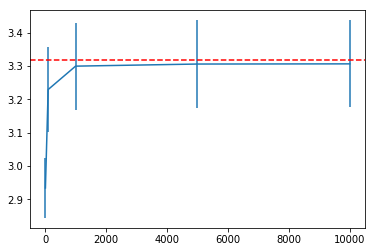

In [7]:
# how many elements for good H calculation?
ys = [y_test[:i] for i in [10,100,1000,5000,10000]]
plt.errorbar([10,100,1000,5000,10000], [h_y_kde(np.float32(0.0735), y)[0] for y in ys], yerr=[h_y_kde(np.float32(0.0735), y)[1] for y in ys])
plt.axhline(y=H_Y, color='r', linestyle='--', label="H(Y)")

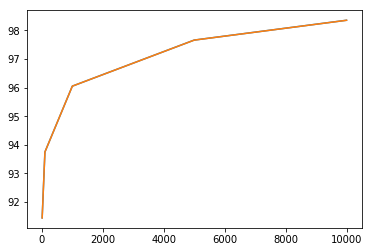

In [8]:
# similar results for x? no, doesn't plateau as early
x_test_vector = x_test.reshape(x_test.shape[0], -1)
xs = [x_test_vector[:i] for i in [10,100,1000,5000,10000]]
plt.plot([10,100,1000,5000,10000], [entropy_func_upper([x,])[0] for x in xs])
plt.plot([10,100,1000,5000,10000], [entropy_func_lower([x,])[0] for x in xs])

# Information Plane Hyperparamters

In [9]:
"""n_saves = 40  # number of batches we want to record
batch_size = 128
n_epochs = 1
batch_per_epoch = np.int(x_train.shape[0]/batch_size)+1
saves_per_epoch = np.int(n_saves/n_epochs)
save_period = np.int(batch_per_epoch/saves_per_epoch)
save_period"""

'n_saves = 40  # number of batches we want to record\nbatch_size = 128\nn_epochs = 1\nbatch_per_epoch = np.int(x_train.shape[0]/batch_size)+1\nsaves_per_epoch = np.int(n_saves/n_epochs)\nsave_period = np.int(batch_per_epoch/saves_per_epoch)\nsave_period'

# Callback

In [0]:
class Logger(Callback):
    def __init__(self, x_test, cnn_mode='mean', epoch_mode='epoch'): 
        self.x_test = x_test
        self.cnn_mode = cnn_mode
        self.epoch_mode = epoch_mode
        self.measures = OrderedDict()
        self.measures['model'] = {}
        self.epoch = 0
        self.batch = 0
        self.iteration = 0
        
    def on_train_begin(self, logs={}):
        lndxs = np.arange(len(self.model.layers))
        conv_mask = np.array([len(layer.output_shape) > 2 for layer in self.model.layers])
        self.convixs = lndxs[conv_mask]  # Indexes of the conv layers
        self.denseixs = lndxs[~conv_mask]  # Indexes of the dense layers
        self.layerfuncs = [K.function(self.model.inputs, [l.output,]) for l in self.model.layers]  # Functions return activity of each layer
        
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch = epoch
        if self.epoch_mode=='epoch': 
            cepochdata = defaultdict(list)
            
            for layerix in self.convixs:
                activity = self.layerfuncs[layerix]([self.x_test,])[0]
                MI_XM_upper, H_M_upper, MI_XM_lower, H_M_lower, MI_YM_upper, MI_YM_lower = np.zeros(6)
                
                if self.cnn_mode == 'mean':
                    MI_XM_upper, H_M_upper, MI_XM_lower, H_M_lower, MI_YM_upper, MI_YM_lower = \
                        np.mean([mi_kde(activity[...,idx].reshape(activity.shape[0], -1)) for idx in range(activity.shape[-1])], axis=0)
                
                if self.cnn_mode == 'concat':
                    activity = activity.reshape(activity.shape[0], -1)  # keep zeroth axis (samples) but flatten everything else
                    MI_XM_upper, H_M_upper, MI_XM_lower, H_M_lower, MI_YM_upper, MI_YM_lower = mi_kde(activity)
                
                if not(self.cnn_mode == 'concat' or self.cnn_mode == 'mean'):
                    print("cnn_mode is not 'mean' or 'concat'")  # unfortunately can't print from here?
                
                cepochdata['MI_XM_upper'].append(MI_XM_upper)
                cepochdata['H_M_upper'  ].append(H_M_upper)
                cepochdata['MI_XM_lower'].append(MI_XM_lower)
                cepochdata['H_M_lower'  ].append(H_M_lower)
                cepochdata['MI_YM_upper'].append(MI_YM_upper)
                cepochdata['MI_YM_lower'].append(MI_YM_lower)

            for layerix in self.denseixs:
                activity = self.layerfuncs[layerix]([self.x_test,])[0]
                MI_XM_upper, H_M_upper, MI_XM_lower, H_M_lower, MI_YM_upper, MI_YM_lower = mi_kde(activity)
                
                cepochdata['MI_XM_upper'].append(MI_XM_upper)
                cepochdata['H_M_upper'  ].append(H_M_upper)
                cepochdata['MI_XM_lower'].append(MI_XM_lower)
                cepochdata['H_M_lower'  ].append(H_M_lower)
                cepochdata['MI_YM_upper'].append(MI_YM_upper)
                cepochdata['MI_YM_lower'].append(MI_YM_lower)
           
            self.measures['model'].update({epoch: cepochdata})
        
    def on_batch_begin(self, batch, logs={}):
        self.batch = batch
        if self.epoch_mode=='batch':
            if  (self.iteration<101 and self.iteration%10==0):  # (0==batch%save_period): # or record every Nth batch - and even batches for first 20 batches
                cepochdata = defaultdict(list)

                for layerix in self.convixs:
                    activity = self.layerfuncs[layerix]([self.x_test,])[0]

                    MI_XM_upper, H_M_upper, MI_XM_lower, H_M_lower, MI_YM_upper, MI_YM_lower = np.zeros(6)

                    if self.cnn_mode == 'mean':
                        MI_XM_upper, H_M_upper, MI_XM_lower, H_M_lower, MI_YM_upper, MI_YM_lower = \
                            np.mean([mi_kde(activity[...,idx].reshape(activity.shape[0], -1)) for idx in range(activity.shape[-1])], axis=0)

                    if self.cnn_mode == 'concat':
                        activity = activity.reshape(activity.shape[0], -1)  # keep zeroth axis (samples) but flatten everything else
                        MI_XM_upper, H_M_upper, MI_XM_lower, H_M_lower, MI_YM_upper, MI_YM_lower = mi_kde(activity)

                    if not(self.cnn_mode == 'concat' or self.cnn_mode == 'mean'):
                        print("cnn_mode is not 'mean' or 'concat'")  # unfortunately can't print from here?

                    cepochdata['MI_XM_upper'].append(MI_XM_upper)
                    cepochdata['MI_YM_upper'].append(MI_YM_upper)
                    cepochdata['MI_XM_lower'].append(MI_XM_lower)
                    cepochdata['H_M_lower'  ].append(H_M_lower)
                    cepochdata['H_M_upper'  ].append(H_M_upper)
                    cepochdata['MI_YM_lower'].append(MI_YM_lower)

                for layerix in self.denseixs:
                    activity = self.layerfuncs[layerix]([self.x_test,])[0]
                    MI_XM_upper, H_M_upper, MI_XM_lower, H_M_lower, MI_YM_upper, MI_YM_lower = mi_kde(activity)

                    cepochdata['MI_XM_upper'].append(MI_XM_upper)
                    cepochdata['H_M_upper'  ].append(H_M_upper)
                    cepochdata['MI_XM_lower'].append(MI_XM_lower)
                    cepochdata['H_M_lower'  ].append(H_M_lower)
                    cepochdata['MI_YM_upper'].append(MI_YM_upper)
                    cepochdata['MI_YM_lower'].append(MI_YM_lower)

                self.measures['model'].update({self.iteration: cepochdata})     
                
    def on_batch_end(self, batch, logs={}):
        self.iteration=self.iteration+1

# IP Plot Function

In [0]:
def plot_IP(measures, err_bars=True, plot_upper=False, plot_pred=True, plot_epoch_idx=None):
    
    max_epoch = max((max(vals.keys()) if len(vals) else 0) for vals in measures.values())
    sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=max_epoch))
    PLOT_LAYERS = np.arange(len(measures['model'][0]['MI_XM_upper']))
    layer_sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=PLOT_LAYERS[-1]))
    sm._A, layer_sm._A = [], []
    fig, ax = plt.subplots(figsize=(8,8))
    
    cbaxes1 = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
    plt.colorbar(sm, label='Batch or Epoch', cax=cbaxes1)

    cbaxes2 = fig.add_axes([1.13, 0.125, 0.03, 0.8]) 
    plt.colorbar(layer_sm, label='Layer', cax=cbaxes2)
    
    plt.tight_layout()
    plt.sca(ax)
    
    plt.xlabel('I(X;M)')
    plt.ylabel('I(Y;M)')
    plt.axhline(y=H_Y, color='r', alpha=0.4, linestyle='--', label="H(Y)")
    #plt.title(activation)

    # MI data of input
    activity = x_test.reshape(x_test.shape[0], -1)
    x_upper, H_M_upper, x_lower, H_M_lower, y_upper, y_lower = mi_kde(activity)

    H_X = 0.5*(x_upper+x_lower)
    plt.axvline(x=H_X, color='r', alpha=0.4, linestyle='--', label="H(X)")
    
    actndx = 0
    activation, vals = next(iter(measures.items()))
    
    epochs = sorted(vals.keys()) 

    if plot_epoch_idx == -1: 
        plot_epoch_idx = len(epochs)-1

    for epoch_idx, epoch in enumerate(epochs):
        if (plot_epoch_idx == epoch_idx or plot_epoch_idx == None):            
            PLOT_LAYERS = np.arange(len(measures['model'][0]['MI_XM_upper']))
            c = sm.to_rgba(epoch)

            x_upper = np.array(vals[epoch]['MI_XM_upper'])[PLOT_LAYERS]
            x_lower = np.array(vals[epoch]['MI_XM_lower'])[PLOT_LAYERS]
            y_upper = np.array(vals[epoch]['MI_YM_upper'])[PLOT_LAYERS]
            y_lower = np.array(vals[epoch]['MI_YM_lower'])[PLOT_LAYERS]

            x = 0.5*(x_upper+x_lower)
            x_err = 0.5*abs(x_upper-x_lower)
            y = 0.5*(y_upper+y_lower)
            y_err = 0.5*abs(y_upper-y_lower)

            if plot_upper:
                err_bars = False
                x = x_upper
                y = y_upper

            if not(plot_pred):
                PLOT_LAYERS = PLOT_LAYERS[:-1]
                x = x[:-1]
                x_err = x_err[:-1]
                y_err = y_err[:-1]
                y = y[:-1]

            plt.plot(x, y, c=c, zorder=0, alpha=0.5)  # line
            if err_bars: plt.errorbar(x, y, yerr=y_err, xerr=x_err, fmt=' ', ecolor=[c for _ in PLOT_LAYERS], alpha=0.4, zorder=5) #errorbars
            plt.scatter(x, y, s=100, facecolors=[layer_sm.to_rgba(i) for i in PLOT_LAYERS], zorder=10)  # dots 
            print(epoch, x)

    plt.show()

# Check with Saxe

In [12]:
def MI_Saxe(x_train, y_train, x_test, y_test):

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)

    model = Sequential()
    model.add(Dense(1024, activation='tanh', input_shape=(784,)))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = SGD(lr=0.001)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    logger_saxe = Logger(x_test, 'concat', 'epoch')  # concat and mean will give same results for MLP
    
    history = model.fit(x_train, y_train, callbacks=[logger_saxe],
                            batch_size=128,
                            epochs=100,
                            verbose=2,
                            validation_data=(x_test, y_test), shuffle=False)  # so we can look at gradients
    
    return logger_saxe, history

logger_saxe, history_saxe = MI_Saxe(x_train, y_train, x_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 3s - loss: 1.9994 - acc: 0.4240 - val_loss: 1.7568 - val_acc: 0.6058
Epoch 2/100
 - 2s - loss: 1.6470 - acc: 0.6389 - val_loss: 1.5470 - val_acc: 0.6655
Epoch 3/100
 - 2s - loss: 1.4807 - acc: 0.6833 - val_loss: 1.4096 - val_acc: 0.6968
Epoch 4/100
 - 2s - loss: 1.3593 - acc: 0.7094 - val_loss: 1.3008 - val_acc: 0.7209
Epoch 5/100
 - 2s - loss: 1.2598 - acc: 0.7279 - val_loss: 1.2089 - val_acc: 0.7378
Epoch 6/100
 - 2s - loss: 1.1746 - acc: 0.7430 - val_loss: 1.1293 - val_acc: 0.7544
Epoch 7/100
 - 2s - loss: 1.1004 - acc: 0.7569 - val_loss: 1.0594 - val_acc: 0.7686
Epoch 8/100
 - 2s - loss: 1.0351 - acc: 0.7688 - val_loss: 0.9977 - val_acc: 0.7827
Epoch 9/100
 - 2s - loss: 0.9772 - acc: 0.7811 - val_loss: 0.9428 - val_acc: 0.7939
Epoch 10/100
 - 2s - loss: 0.9257 - acc: 0.7930 - val_loss: 0.8938 - val_a

0 [13.28771057 12.15300921 10.4710464   8.81533089  0.11757611]
1 [13.28771057 12.4678035  11.43140715 10.17096281  0.46518916]
2 [13.2877546  12.52822995 11.50805225 10.26299967  0.86035267]
3 [13.28766654 12.55046799 11.52763901 10.32163338  1.20178191]
4 [13.28771057 12.56096994 11.53710631 10.3745999   1.513852  ]
5 [13.28771057 12.56428026 11.54004791 10.41847612  1.80141559]
6 [13.28771057 12.5630131  11.53820838 10.45361149  2.06286155]
7 [13.28771057 12.55905337 11.5332828  10.48162402  2.29529507]
8 [13.28771057 12.5536366  11.52657685 10.50421704  2.49747857]
9 [13.28771057 12.54751127 11.51900824 10.5226577   2.67061935]
10 [13.28771057 12.54112727 11.51117271 10.53775365  2.81772092]
11 [13.2877546  12.53478593 11.50344587 10.55012815  2.94259237]
12 [13.28771057 12.528717   11.49608639 10.56030952  3.04907611]
13 [13.28771057 12.52309936 11.48927175 10.56872154  3.14059943]
14 [13.28771057 12.51805683 11.48311339 10.57570954  3.21996908]
15 [13.28771057 12.51365545 11.4776

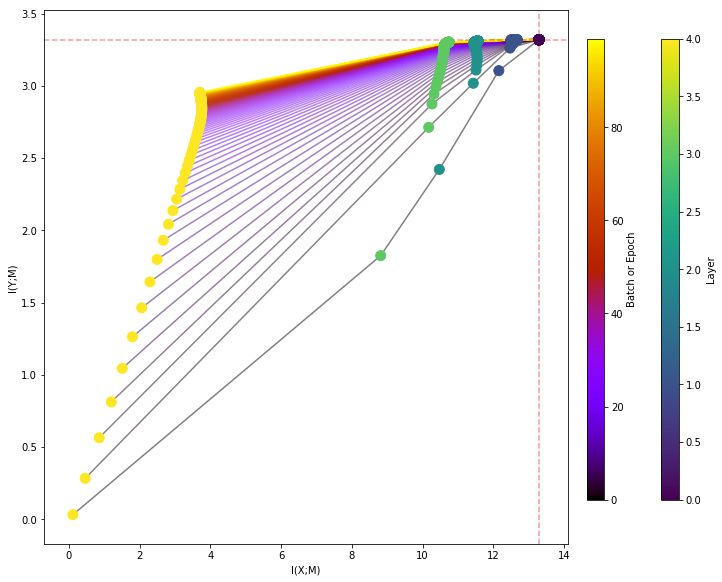

In [13]:
plot_IP(logger_saxe.measures, err_bars=False, plot_upper=True)

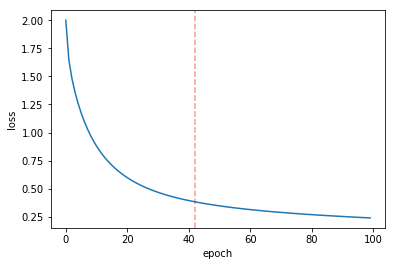

In [14]:
plt.plot(history_saxe.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.axvline(x=42, color='r', alpha=0.4, linestyle='--', label="transition")
plt.show()

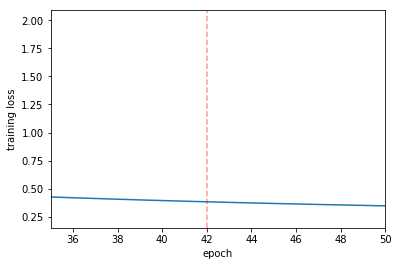

In [15]:
plt.plot(history_saxe.history['loss'])
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.xlim([35,50])
plt.axvline(x=42, color='r', alpha=0.4, linestyle='--', label="transition")
plt.show()

# CNN Architecture

In [0]:
def make_conv():
  
    conv = Sequential()
    #input
    conv.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)))
    conv.add(Conv2D(64, (3, 3), activation='relu'))
    conv.add(MaxPooling2D((2, 2)))
    conv.add(Flatten())
    conv.add(Dense(128, activation='relu'))
    #prediction
    conv.add(Dense(num_classes, activation='softmax'))
    #conv.summary()
    
    return conv

# Concat and Mean Method

In [17]:
conv = make_conv()
conv.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
logger_concat = Logger(x_test, "concat", 'batch')
logger_mean = Logger(x_test, "mean", 'batch')

score_untrain = conv.evaluate(x_test, y_test, verbose=0)
print('Test loss (untrained):', score_untrain[0])  # should be -ln(0.1) = 2.302 (https://cs231n.github.io/neural-networks-3/)
print('Test accuracy (untrained):', score_untrain[1])  # should be 10%

history = conv.fit(x_train, y_train, callbacks=[logger_concat, logger_mean], epochs=1, batch_size=128, verbose=1, validation_data=(x_test, y_test))

score_train = conv.evaluate(x_test, y_test, verbose=0)
print('Test loss (trained):', score_train[0])
print('Test accuracy (trained):', score_train[1])

Test loss (untrained): 2.296466470336914
Test accuracy (untrained): 0.0917
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 951s 16ms/step - loss: 0.1940 - acc: 0.9418 - val_loss: 0.0619 - val_acc: 0.9808
Test loss (trained): 0.0618729085246101
Test accuracy (trained): 0.9808


#Plot full plots

0 [1.32850863e+01 1.32631312e+01 1.29572898e+01 1.29572898e+01
 8.29618949e-01 1.15778387e-03]
10 [13.29565288 13.30469326 13.25526834 13.25526834 11.1874791   1.14280837]
20 [13.3097417  13.32159985 13.28362208 13.28362208 12.91258066  2.66558266]
30 [13.27945074 13.32864425 13.29172315 13.29172315 13.11380036  3.07284721]
40 [13.2857907  13.32653093 13.29013816 13.29013816 13.12559425  3.20202802]
50 [13.29917508 13.30046662 13.29066649 13.29066649 13.17076652  3.16223141]
60 [13.2857907  13.32300873 13.29119482 13.29119482 13.17581593  3.22311189]
70 [13.30762837 13.32864425 13.29119482 13.29119482 13.18954152  3.22540459]
80 [13.31960387 13.32653093 13.29119482 13.29119482 13.17263769  3.20595525]
90 [13.29494844 13.30680659 13.29013816 13.29013816 13.18167985  3.20873036]
100 [13.33580601 13.32512205 13.28943372 13.28943372 13.22790053  3.21710832]


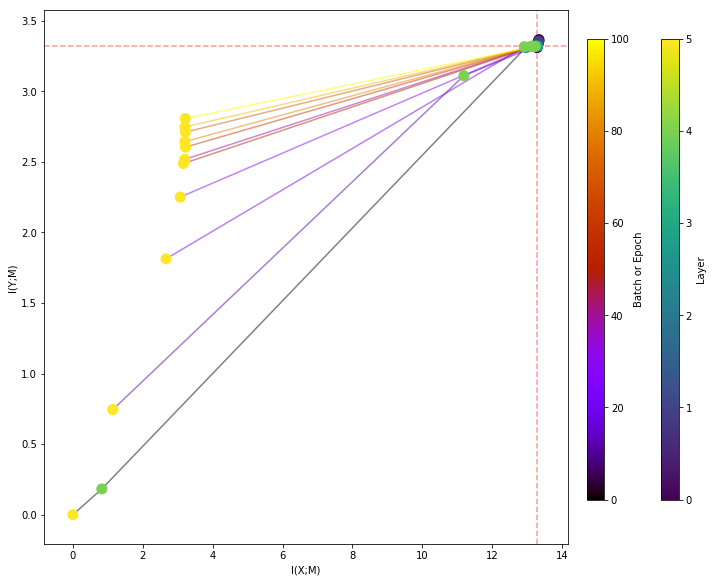

In [18]:
plot_IP(logger_concat.measures, err_bars=False)

0 [5.26869406e+00 2.67393165e+00 1.16093064e+00 1.29572898e+01
 8.29618949e-01 1.15778387e-03]
10 [ 6.29728309  6.22781795  3.76240957 13.25526834 11.1874791   1.14280837]
20 [ 7.27535805  8.1068727   5.62506569 13.28362208 12.91258066  2.66558266]
30 [ 8.03368391  9.46204233  7.01132811 13.29172315 13.11380036  3.07284721]
40 [ 8.4859202   9.71279889  7.25875632 13.29013816 13.12559425  3.20202802]
50 [ 8.68506407 10.21668071  7.87814707 13.29066649 13.17076652  3.16223141]
60 [ 8.97054461 10.42058919  8.08956104 13.29119482 13.17581593  3.22311189]
70 [ 9.12880614 10.51698925  8.19692091 13.29119482 13.18954152  3.22540459]
80 [ 9.14504405 10.37167543  8.05782009 13.29119482 13.17263769  3.20595525]
90 [ 9.57440252 10.5020314   8.1549227  13.29013816 13.18167985  3.20873036]
100 [ 9.72853681 11.03867282  8.86605308 13.28943372 13.22790053  3.21710832]


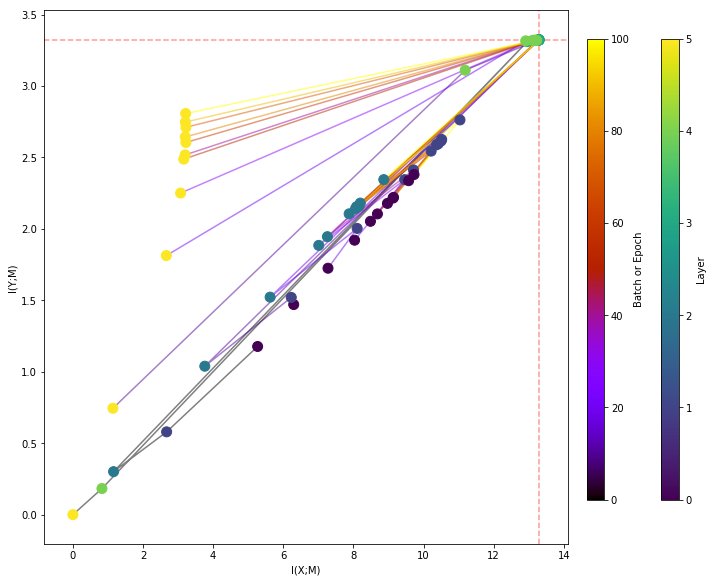

In [19]:
plot_IP(logger_mean.measures, err_bars=False)

# Plot Start and End

0 [1.32850863e+01 1.32631312e+01 1.29572898e+01 1.29572898e+01
 8.29618949e-01 1.15778387e-03]


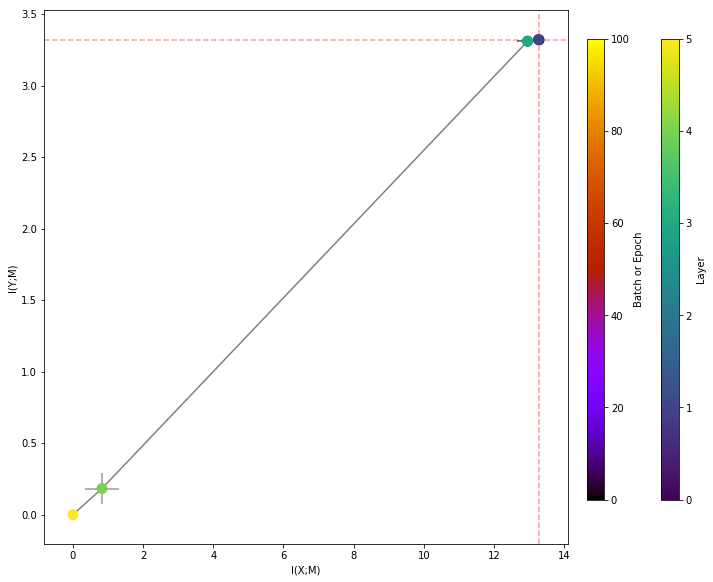

100 [13.33580601 13.32512205 13.28943372 13.28943372 13.22790053  3.21710832]


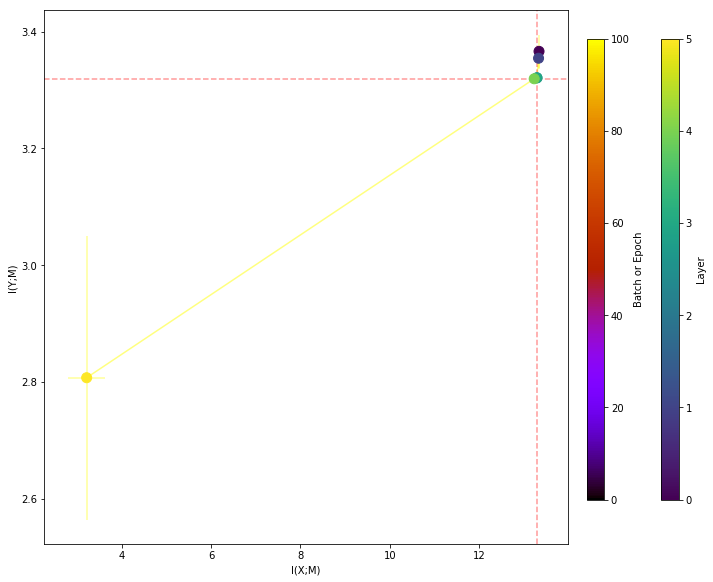

In [20]:
plot_IP(logger_concat.measures, plot_epoch_idx=0)
plot_IP(logger_concat.measures, plot_epoch_idx=-1)

0 [5.26869406e+00 2.67393165e+00 1.16093064e+00 1.29572898e+01
 8.29618949e-01 1.15778387e-03]


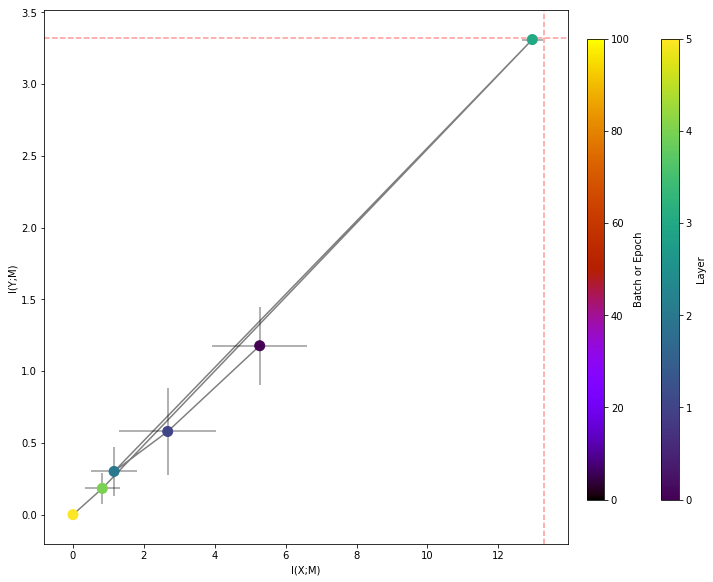

100 [ 9.72853681 11.03867282  8.86605308 13.28943372 13.22790053  3.21710832]


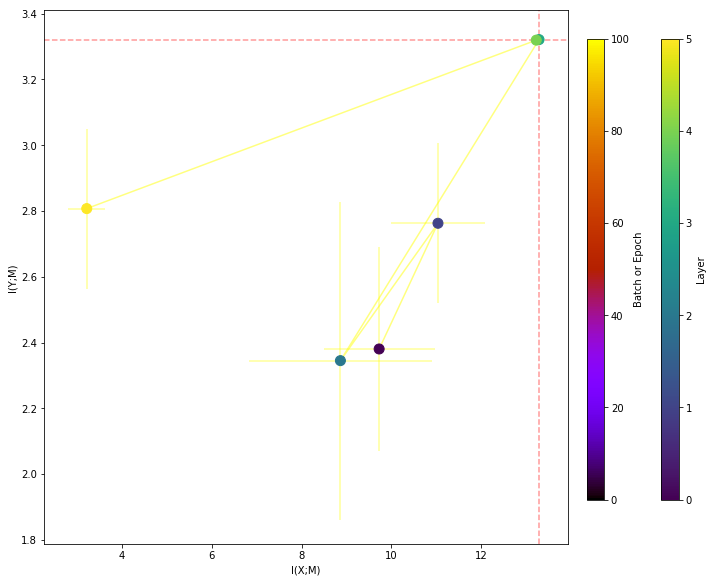

In [21]:
plot_IP(logger_mean.measures, plot_epoch_idx=0)
plot_IP(logger_mean.measures, plot_epoch_idx=-1)

# Plot Movies

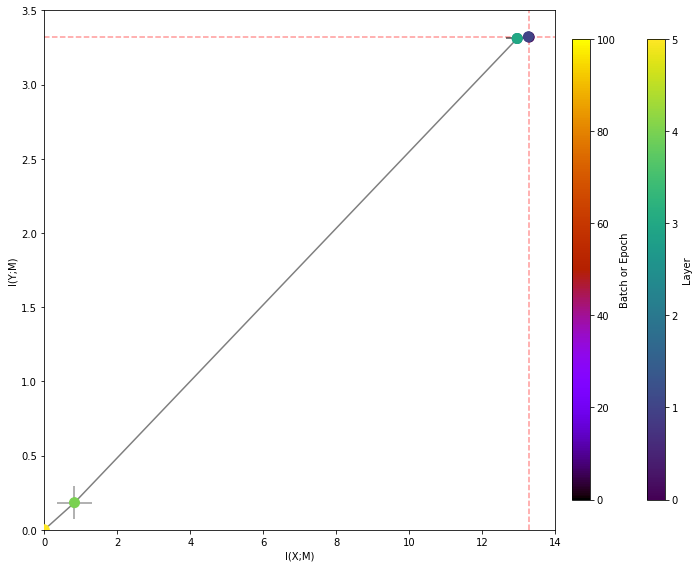

In [22]:
measures = logger_concat.measures
actndx = 0
activation, vals = next(iter(measures.items()))

max_epoch = max((max(vals.keys()) if len(vals) else 0) for vals in measures.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=max_epoch))
PLOT_LAYERS = np.arange(len(measures['model'][0]['MI_XM_upper']))
layer_sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=PLOT_LAYERS[-1]))
sm._A, layer_sm._A = [], []
fig, ax = plt.subplots(figsize=(8,8))

cbaxes1 = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
plt.colorbar(sm, label='Batch or Epoch', cax=cbaxes1)

cbaxes2 = fig.add_axes([1.13, 0.125, 0.03, 0.8]) 
plt.colorbar(layer_sm, label='Layer', cax=cbaxes2)

plt.tight_layout()

plt.sca(ax)

#plt.title(activation)

# MI data of input
activity = x_test.reshape(x_test.shape[0], -1)
x_upper, H_M_upper, x_lower, H_M_lower, y_upper, y_lower = mi_kde(activity)
H_X = 0.5*(x_upper+x_lower)


def animate(i):
    plt.sca(ax)
    plt.cla()
    plt.sca(ax)
    
    plt.axhline(y=H_Y, color='r', alpha=0.4, linestyle='--', label="H(Y)")
    plt.axvline(x=H_X, color='r', alpha=0.4, linestyle='--', label="H(X)")
    ax.set_xlim([0,14])
    ax.set_ylim([0,3.5])
    plt.xlabel('I(X;M)')
    plt.ylabel('I(Y;M)')
    plt.tight_layout()

    epochs = sorted(vals.keys()) 
    epoch = epochs[i]
    PLOT_LAYERS = np.arange(len(measures['model'][0]['MI_XM_upper']))
    c = sm.to_rgba(epoch)

    x_upper = np.array(vals[epoch]['MI_XM_upper'])[PLOT_LAYERS]
    x_lower = np.array(vals[epoch]['MI_XM_lower'])[PLOT_LAYERS]
    y_upper = np.array(vals[epoch]['MI_YM_upper'])[PLOT_LAYERS]
    y_lower = np.array(vals[epoch]['MI_YM_lower'])[PLOT_LAYERS]

    x = 0.5*(x_upper+x_lower)
    x_err = 0.5*abs(x_upper-x_lower)
    y = 0.5*(y_upper+y_lower)
    y_err = 0.5*abs(y_upper-y_lower)

    plt.plot(x, y, c=c, zorder=0, alpha=0.5)  # line
    plt.errorbar(x, y, yerr=y_err, xerr=x_err, fmt=' ', ecolor=[c for _ in PLOT_LAYERS], alpha=0.4, zorder=5) #errorbars
    plt.scatter(x, y, s=100, facecolors=[layer_sm.to_rgba(i) for i in PLOT_LAYERS], zorder=10)  # dots 
    #plt.show()

ani = animation.FuncAnimation(fig, animate, frames=10, interval=300, repeat=True)
HTML(ani.to_html5_video())

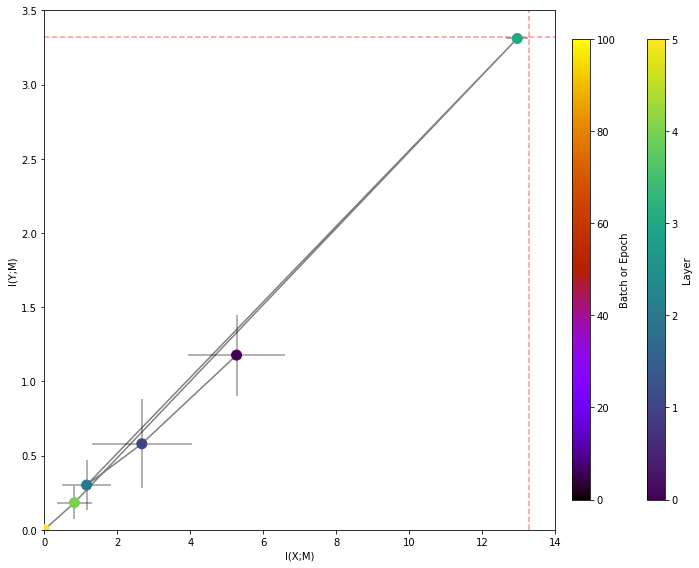

In [23]:
measures = logger_mean.measures
actndx = 0
activation, vals = next(iter(measures.items()))

max_epoch = max((max(vals.keys()) if len(vals) else 0) for vals in measures.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=max_epoch))
PLOT_LAYERS = np.arange(len(measures['model'][0]['MI_XM_upper']))
layer_sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=PLOT_LAYERS[-1]))
sm._A, layer_sm._A = [], []
fig, ax = plt.subplots(figsize=(8,8))

cbaxes1 = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
plt.colorbar(sm, label='Batch or Epoch', cax=cbaxes1)

cbaxes2 = fig.add_axes([1.13, 0.125, 0.03, 0.8]) 
plt.colorbar(layer_sm, label='Layer', cax=cbaxes2)

plt.tight_layout()

plt.sca(ax)

#plt.title(activation)

# MI data of input
activity = x_test.reshape(x_test.shape[0], -1)
x_upper, H_M_upper, x_lower, H_M_lower, y_upper, y_lower = mi_kde(activity)
H_X = 0.5*(x_upper+x_lower)


def animate(i):
    plt.sca(ax)
    plt.cla()
    plt.sca(ax)
    
    plt.axhline(y=H_Y, color='r', alpha=0.4, linestyle='--', label="H(Y)")
    plt.axvline(x=H_X, color='r', alpha=0.4, linestyle='--', label="H(X)")
    ax.set_xlim([0,14])
    ax.set_ylim([0,3.5])
    plt.xlabel('I(X;M)')
    plt.ylabel('I(Y;M)')
    plt.tight_layout()

    epochs = sorted(vals.keys()) 
    epoch = epochs[i]
    PLOT_LAYERS = np.arange(len(measures['model'][0]['MI_XM_upper']))
    c = sm.to_rgba(epoch)

    x_upper = np.array(vals[epoch]['MI_XM_upper'])[PLOT_LAYERS]
    x_lower = np.array(vals[epoch]['MI_XM_lower'])[PLOT_LAYERS]
    y_upper = np.array(vals[epoch]['MI_YM_upper'])[PLOT_LAYERS]
    y_lower = np.array(vals[epoch]['MI_YM_lower'])[PLOT_LAYERS]

    x = 0.5*(x_upper+x_lower)
    x_err = 0.5*abs(x_upper-x_lower)
    y = 0.5*(y_upper+y_lower)
    y_err = 0.5*abs(y_upper-y_lower)

    plt.plot(x, y, c=c, zorder=0, alpha=0.5)  # line
    plt.errorbar(x, y, yerr=y_err, xerr=x_err, fmt=' ', ecolor=[c for _ in PLOT_LAYERS], alpha=0.4, zorder=5) #errorbars
    plt.scatter(x, y, s=100, facecolors=[layer_sm.to_rgba(i) for i in PLOT_LAYERS], zorder=10)  # dots 
    #plt.show()

ani = animation.FuncAnimation(fig, animate, frames=10, interval=300, repeat=True)
HTML(ani.to_html5_video())

#Plotting Activations

In [24]:
conv = make_conv()
conv.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])

score_untrain = conv.evaluate(x_test, y_test, verbose=0)
print('Test loss (untrained):', score_untrain[0])  # should be -ln(0.1) = 2.302 (https://cs231n.github.io/neural-networks-3/)
print('Test accuracy (untrained):', score_untrain[1])  # should be 10%

history = conv.fit(x_train, y_train, epochs=1, batch_size=128, verbose=1, validation_data=(x_test, y_test))

score_train = conv.evaluate(x_test, y_test, verbose=0)
print('Test loss (trained):', score_train[0])
print('Test accuracy (trained):', score_train[1])

Test loss (untrained): 2.3009514850616455
Test accuracy (untrained): 0.0947
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 5s 77us/step - loss: 0.1943 - acc: 0.9410 - val_loss: 0.0507 - val_acc: 0.9841
Test loss (trained): 0.05070388049678877
Test accuracy (trained): 0.9841


In [0]:
from keras import models

def make_act_model(conv):
    layer_outputs = [layer.output for layer in conv.layers]
    # Creates a model that will return activations from conv input:
    activation_model = models.Model(inputs=conv.input, outputs=layer_outputs)
    return activation_model

In [0]:
# Plotting input and activations
def plot_activations(conv, activations, x_activation, x_activation_indx):

    #plot input
    plt.imshow(np.squeeze(x_activation[x_activation_indx]), cmap=plt.get_cmap('gray'), interpolation = 'none')
    plt.axis('off')
    plt.show()

    # These are the names of the layers, so can have them as part of our plot
    layer_names = conv.layers

    for layer_name, layer_activation in zip(layer_names, activations):
        if len(layer_activation.shape) > 2:  # convolutional layer 
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.show()
            n_elem_row = 10
            n_elements = layer_activation.shape[-1]
            plt.axis('off')
            for element in range(n_elements):
                plt.subplot(1+n_elements/n_elem_row, n_elem_row, element+1)
                plt.imshow(layer_activation[x_activation_indx, :, :, element], cmap=plt.get_cmap('gray'), interpolation = 'none')
                plt.axis('off')
            #plt.suptitle(layer_name)
            #plt.tight_layout()
            plt.show()

        else: # dense layer
            vector = layer_activation[x_activation_indx]
            vector_2d = np.expand_dims(vector, axis=0)
            plt.imshow(vector_2d, cmap=plt.get_cmap('gray'), interpolation = 'none')
            plt.axis('off')
            #plt.suptitle(layer_name)
            plt.show()

In [0]:
def frame_image(img, frame_width):
    b = frame_width # border size in pixel
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    if img.ndim == 3: # rgb or rgba array
        framed_img = np.zeros((b+ny+b, b+nx+b, img.shape[2]))
    elif img.ndim == 2: # grayscale image
        framed_img = np.zeros((b+ny+b, b+nx+b))
    framed_img[b:-b, b:-b] = img
    return framed_img

In [0]:
#get untrained model
conv_untrained = make_conv()
act_model_untrained = make_act_model(conv_untrained)

# copy trained model
conv_trained = conv
act_model_trained = make_act_model(conv_trained)

x_activation = x_test[:10]

# This will return a list of Numpy arrays, one array per layer activation
activations_untrain = act_model_untrained.predict(x_activation)
activations_train = act_model_trained.predict(x_activation)

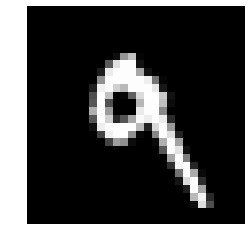

<Figure size 432x288 with 0 Axes>

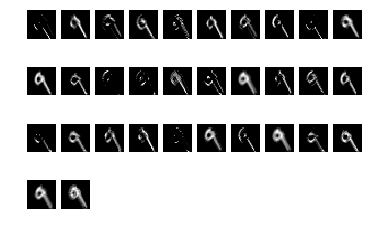

<Figure size 432x288 with 0 Axes>

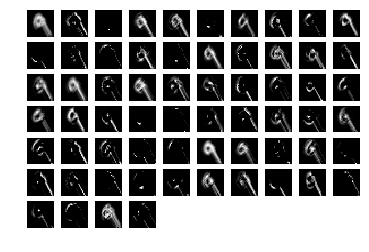

<Figure size 432x288 with 0 Axes>

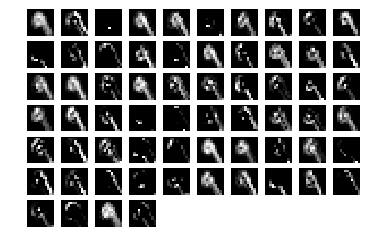

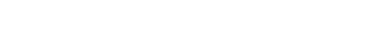

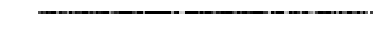

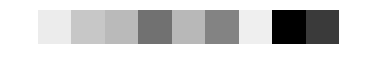

In [29]:
print_indx = 7

#plotting untrained model
plot_activations(conv_untrained, activations_untrain, x_activation, print_indx)

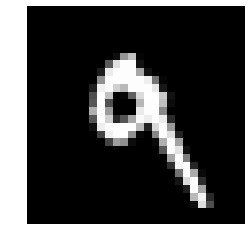

<Figure size 432x288 with 0 Axes>

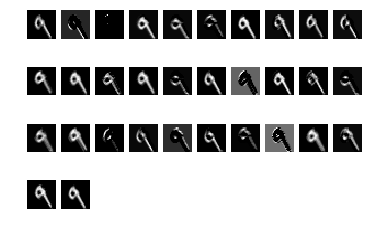

<Figure size 432x288 with 0 Axes>

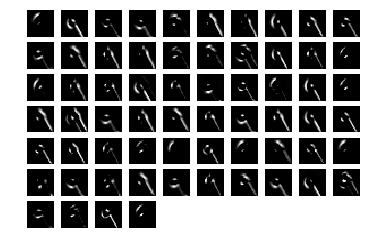

<Figure size 432x288 with 0 Axes>

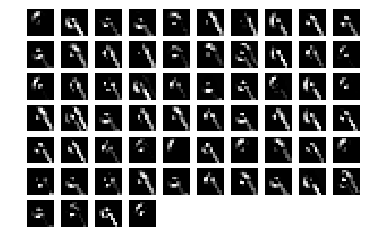

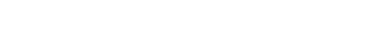

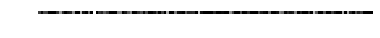

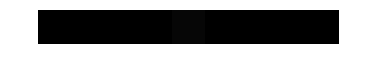

In [30]:
#plotting activations for trained model
plot_activations(conv_trained, activations_train, x_activation, print_indx)

# Development

# automatically detect transition

# Gradients

In [0]:
import keras as keras

class Gradients(keras.callbacks.Callback):
    def __init__(self, x_train, y_train):
        self.x_train = x_train  
        self.y_train = y_train
        
    def on_train_begin(self, logs={}):
        self._data = []
        input_tensors = [self.model.inputs[0],
                         self.model.sample_weights[0],
                         self.model.targets[0],
                         K.learning_phase()]
        grads = K.gradients(self.model.total_loss, self.model.trainable_weights)
        self.get_gradients = K.function(inputs=input_tensors, outputs=grads)

    def on_batch_end(self, batch, logs={}):
        self.batch = batch
        self.batch_size = 128
        self.batch_input = self.x_train[self.batch*self.batch_size : (self.batch + 1)*self.batch_size]
        self.batch_y = self.y_train[self.batch*self.batch_size : (self.batch + 1)*self.batch_size]
        inputs = [self.batch_input,  
                  [1,]*self.batch_input.shape[0],      
                  self.batch_y,  
                  1]    # Training phase
        gradient = self.get_gradients(inputs)
        self._data.append({'gradient': gradient})